In [3]:
import pyspark
import boto3
from zipfile import ZipFile
from string import punctuation, digits
from pyspark.sql.types import BooleanType
from pyspark.sql.functions import udf
from pyspark.sql import functions as F
from pyspark.sql import SparkSession, DataFrame
from pyspark.ml import Pipeline
from pyspark.ml.feature import  NGram, Tokenizer,CountVectorizer, StopWordsRemover
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
#download dataset from s3 bucket
s3_client.download_file(bucket, "data-scientist-job-market-in-the-us.zip", '../data/data-scientist-job-market-in-the-us.zip')

In [50]:
#download dataset from s3 bucket
s3_client.download_file(bucket, "all-us-stocks-tickers-company-info-logos.zip", '../data/all-us-stocks-tickers-company-info-logos.zip')

In [52]:
# assign zip file path to variable
zipfilepath1='../data/data-scientist-job-market-in-the-us.zip'
zipfilepath2='../data/all-us-stocks-tickers-company-info-logos.zip'

In [48]:
# extract files (print comments serve as a log)
with ZipFile(zipfilepath1, 'r') as zip:
    zip.printdir()
    print("extract files")
    zip.extractall()
    print("are files extracted")

File Name                                             Modified             Size
alldata.csv                                    2019-10-04 22:08:26     26925500
fulltimeAL.csv                                 2019-10-04 22:08:28      1240633
fulltimeAT.csv                                 2019-10-04 22:08:28      1017293
fulltimeBO.csv                                 2019-10-04 22:08:28      1409979
fulltimeBOS.csv                                2019-10-04 22:08:28      2593568
fulltimeCHI.csv                                2019-10-04 22:08:28      2078496
fulltimeDC.csv                                 2019-10-04 22:08:30      1649712
fulltimeLA.csv                                 2019-10-04 22:08:30      1028997
fulltimeMA.csv                                 2019-10-04 22:08:30      2899236
fulltimeMV.csv                                 2019-10-04 22:08:30      1035096
fulltimeNY.csv                                 2019-10-04 22:08:30      4207217
fulltimeRM.csv                          

In [53]:
# extract files (print comments serve as a log)
with ZipFile(zipfilepath2, 'r') as zip:
    zip.printdir()
    print("extract files")
    zip.extractall()
    print("are files extracted")

File Name                                             Modified             Size
logos.zip                                      2019-02-06 11:07:28     33109728
companies.csv                                  2019-02-06 11:07:28      2946449
extract files
are files extracted


In [7]:
spark = SparkSession.builder.getOrCreate()

In [8]:
ds = spark.read.csv("alldata.csv", header=True, inferSchema=True)
companies = spark.read.csv("companies.csv", header=True, inferSchema=True)

In [10]:
# display all columns in dataframe
companies.columns

['ticker',
 'company name',
 'short name',
 'industry',
 'description',
 'website',
 'logo',
 'ceo',
 'exchange',
 'market cap',
 'sector',
 'tag 1',
 'tag 2',
 'tag 3']

In [11]:
companies = companies.filter(companies.description.isNotNull())
companies.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+
|              ticker|        company name|          short name|            industry|         description|             website|     logo|                 ceo|            exchange|  market cap|              sector|               tag 1|               tag 2|               tag 3|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+
|                   A|Agilent Technolog...|             Agilent|Medical Diagnosti...|Agilent Technolog...|http://www.agilen...|    A.png| Michael R. McMullen|New York St

In [12]:
companies.select('description').show()

+--------------------+
|         description|
+--------------------+
|Agilent Technolog...|
|Alcoa Corp is an ...|
|Altaba Inc is an ...|
|AAC Holdings Inc ...|
|The investment se...|
|American Airlines...|
|Altisource Asset ...|
|Atlantic American...|
|Aaron's Inc is a ...|
|Applied Optoelect...|
|AAON Inc is a hea...|
|Advance Auto Part...|
|Apple Inc is desi...|
|American Assets T...|
|Almaden Minerals ...|
|Atlas Air Worldwi...|
|The investment se...|
|           Indonesia|
|Axon Enterprise I...|
|AllianceBernstein...|
+--------------------+
only showing top 20 rows



In [13]:
# display all columns in dataframe
ds.columns

['position', 'company', 'description', 'reviews', 'location']

In [14]:
# rename column
ds = ds.withColumnRenamed('description', 'jobdescription')

In [15]:
# rename column
companies = companies.withColumnRenamed('description', 'companydescription')

In [16]:
# filter null from location column
ds = ds.filter(ds.location.isNotNull())

In [17]:
ds.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|            position|             company|      jobdescription|             reviews|            location|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|ALS Therapy Devel...| the Development ...| generating aware...| prospects and do...|                 GA.|
|Bachelor's Degree...| written and pres...| as well as the a...|         spreadsheet|            database|
|The ALS Therapy D...| the charity unde...|  based in Cambridge|                  MA| has served as on...|
|      With that said|             Atlanta| Georgia-based sc...|     Hexagon Lavish®| has an open posi...|
|Ph.D. in Computer...|         Mathematics|          Statistics|           Chemistry| or other quantit...|
| 5+ years experience| with varying dat...|         Mathematics|    Computer Science| Algorithms/Incor...|
|Interact with sta...|             bi

In [18]:
ds = ds.filter(ds.location.isNotNull()).withColumn('location', F.split(ds['location'], ',')[0].alias('city'))

In [19]:
ds.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|            position|             company|      jobdescription|             reviews|            location|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|ALS Therapy Devel...| the Development ...| generating aware...| prospects and do...|                 GA.|
|Bachelor's Degree...| written and pres...| as well as the a...|         spreadsheet|            database|
|The ALS Therapy D...| the charity unde...|  based in Cambridge|                  MA| has served as on...|
|      With that said|             Atlanta| Georgia-based sc...|     Hexagon Lavish®| has an open posi...|
|Ph.D. in Computer...|         Mathematics|          Statistics|           Chemistry| or other quantit...|
| 5+ years experience| with varying dat...|         Mathematics|    Computer Science| Algorithms/Incor...|
|Interact with sta...|             bi

In [20]:
# join the two dataframes 
joined_data = companies.join(ds,companies.companydescription == ds.jobdescription)

In [21]:
# display all columns in dataframe
joined_data.columns

['ticker',
 'company name',
 'short name',
 'industry',
 'companydescription',
 'website',
 'logo',
 'ceo',
 'exchange',
 'market cap',
 'sector',
 'tag 1',
 'tag 2',
 'tag 3',
 'position',
 'company',
 'jobdescription',
 'reviews',
 'location']

In [22]:
tokens = Tokenizer(inputCol='companydescription', outputCol='tokens')
df = tokens.transform(companies)

In [23]:
ngrams = NGram(n=2, inputCol='tokens', outputCol='ngrams')
df = ngrams.transform(df)

In [24]:
# display all columns in dataframe
df.columns

['ticker',
 'company name',
 'short name',
 'industry',
 'companydescription',
 'website',
 'logo',
 'ceo',
 'exchange',
 'market cap',
 'sector',
 'tag 1',
 'tag 2',
 'tag 3',
 'tokens',
 'ngrams']

In [26]:
df.select('ngrams').limit(1).take(2)

[Row(ngrams=['agilent technologies', 'technologies inc', 'inc is', 'is engaged', 'engaged in', 'in life', 'life sciences,', 'sciences, diagnostics', 'diagnostics and', 'and applied', 'applied chemical', 'chemical markets.', 'markets. the', 'the company', 'company provides', 'provides application', 'application focused', 'focused solutions', 'solutions that', 'that include', 'include instruments,', 'instruments, software,', 'software, services', 'services and', 'and consumables', 'consumables for', 'for the', 'the entire', 'entire laboratory', 'laboratory workflow.'])]

In [27]:
new = df.select(['ngrams','industry']).limit(5).select(
    'industry',F.explode('ngrams').alias('ngrams')).show()

+--------------------+--------------------+
|            industry|              ngrams|
+--------------------+--------------------+
|Medical Diagnosti...|agilent technologies|
|Medical Diagnosti...|    technologies inc|
|Medical Diagnosti...|              inc is|
|Medical Diagnosti...|          is engaged|
|Medical Diagnosti...|          engaged in|
|Medical Diagnosti...|             in life|
|Medical Diagnosti...|      life sciences,|
|Medical Diagnosti...|sciences, diagnos...|
|Medical Diagnosti...|     diagnostics and|
|Medical Diagnosti...|         and applied|
|Medical Diagnosti...|    applied chemical|
|Medical Diagnosti...|   chemical markets.|
|Medical Diagnosti...|        markets. the|
|Medical Diagnosti...|         the company|
|Medical Diagnosti...|    company provides|
|Medical Diagnosti...|provides application|
|Medical Diagnosti...| application focused|
|Medical Diagnosti...|   focused solutions|
|Medical Diagnosti...|      solutions that|
|Medical Diagnosti...|        th

In [28]:
industry_frequency = df.groupBy('industry','ngrams')\
        .count().sort('count', ascending=False)\
        .filter(df.industry.isNotNull() & df.ngrams.isNotNull())

In [29]:
industry_frequency.show()

+--------------------+--------------------+-----+
|            industry|              ngrams|count|
+--------------------+--------------------+-----+
|http://www.prosha...|                  []|   34|
|http://www.ftport...|                  []|   30|
|http://www.invesc...|                  []|   29|
|http://www.ishare...|                  []|   22|
| as well as in se...|[ but, but which,...|   21|
| of its assets in...|[ holding, holdin...|   14|
| holding each sto...|                  []|    8|
|http://www.wisdom...|                  []|    7|
| excluding amount...|                  []|    6|
| ""blue-chip"" U....|[ excluding, excl...|    5|
|   futures contracts|[ short, short po...|    5|
|http://www.direxi...|                  []|    5|
|000 companies in ...|                  []|    4|
| plus the amount ...|[ in, in the, the...|    4|
|       Entertainment|[discovery inc, i...|    3|
| taxable securiti...|          [ utility]|    3|
| as well as Ameri...|                  []|    3|


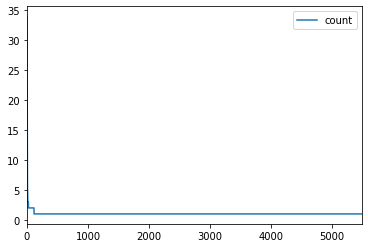

In [45]:
display = industry_frequency.toPandas()
display[['count']].plot()
plt.show()

In [32]:
tokens = Tokenizer(inputCol='jobdescription', outputCol='tokens')
newds = tokens.transform(ds)

In [33]:
dsngrams = NGram(n=2, inputCol='tokens', outputCol='dsngrams')
newds = dsngrams.transform(newds)

In [34]:
# display all columns in dataframe
newds.columns

['position',
 'company',
 'jobdescription',
 'reviews',
 'location',
 'tokens',
 'dsngrams']

In [37]:
newds.select('dsngrams').limit(1).take(2)

[Row(dsngrams=[' generating', 'generating awareness', 'awareness of', 'of als', 'als tdi;', 'tdi; outreach', 'outreach including', 'including attending', 'attending and', 'and speaking', 'speaking at', 'at events', 'events as', 'as well', 'well as', 'as personally', 'personally cultivates', 'cultivates relationships', 'relationships with', 'with patients'])]

In [38]:
ds.select('location').show()

+--------------------+
|            location|
+--------------------+
|                 GA.|
|            database|
| has served as on...|
| has an open posi...|
| or other quantit...|
| Algorithms/Incor...|
| regulatory and p...|
| impactful solutions|
|             Atlanta|
| signal processin...|
|     cloud computing|
| with expert supp...|
| and a vibrant ec...|
|           designers|
|             back-up|
| responding to us...|
|     including sales|
| and a vibrant ec...|
|           designers|
|     data scientists|
+--------------------+
only showing top 20 rows



In [39]:
new1 = newds.filter(ds.location.isNotNull()).select(['dsngrams','location']).limit(5).select(
    'location',F.explode('dsngrams').alias('dsngrams')).show()

+--------+--------------------+
|location|            dsngrams|
+--------+--------------------+
|     GA.|          generating|
|     GA.|generating awareness|
|     GA.|        awareness of|
|     GA.|              of als|
|     GA.|            als tdi;|
|     GA.|       tdi; outreach|
|     GA.|  outreach including|
|     GA.| including attending|
|     GA.|       attending and|
|     GA.|        and speaking|
|     GA.|         speaking at|
|     GA.|           at events|
|     GA.|           events as|
|     GA.|             as well|
|     GA.|             well as|
|     GA.|       as personally|
|     GA.|personally cultiv...|
|     GA.|cultivates relati...|
|     GA.|  relationships with|
|     GA.|       with patients|
+--------+--------------------+
only showing top 20 rows



In [40]:
location_frequency = newds.filter(ds.location.isNotNull()).groupBy('location','dsngrams')\
        .count().sort('count', ascending=True)

In [41]:
location_frequency.show()

+--------------------+--------------------+-----+
|            location|            dsngrams|count|
+--------------------+--------------------+-----+
| engineering or r...|      [ mathematics]|    1|
| and increase cap...|[ and, and moneta...|    1|
| and creative thi...|[ commitment, com...|    1|
| South Jersey / P...|[ northern, north...|    1|
| and MS Office (i...|[ adobe, adobe cr...|    1|
| innovation and r...|           [ region]|    1|
|       communication|       [ facilitate]|    1|
| and training and...|[ internal, inter...|    1|
| and other clinic...|[ study, study ma...|    1|
|           economics|[ statistics, sta...|    1|
| and work with Pa...|      [ reliability]|    1|
| as it is incredi...|[ fascinating, fa...|    1|
| Commercial Real ...|[ government, gov...|    1|
|     factor analysis|[ predictive, pre...|    1|
|            analysis|[ applying, apply...|    1|
|               HBase|            [ kafka]|    1|
|                 VPN|        [ firewalls]|    1|


In [42]:
# display all columns in dataframe
location_frequency.columns

['location', 'dsngrams', 'count']

In [43]:
location_frequency.dtypes

[('location', 'string'), ('dsngrams', 'array<string>'), ('count', 'bigint')]

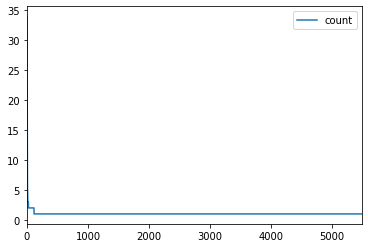

In [46]:
locdisplay = industry_frequency.toPandas()
locdisplay[['count']].plot()
plt.show()

In [48]:
# check type for ds dataframe
type(ds)

pyspark.sql.dataframe.DataFrame